# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.43.0
    Uninstalling wheel-0.43.0:
      Successfully uninstalled wheel-0.43.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.3 requires setuptools>65.5.1, but you have setuptools 65.5.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 19.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
INFO: pip is looking at multiple versions of shimmy[atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu2_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu2) ...
Selecting previously unselected package xfonts-util

## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


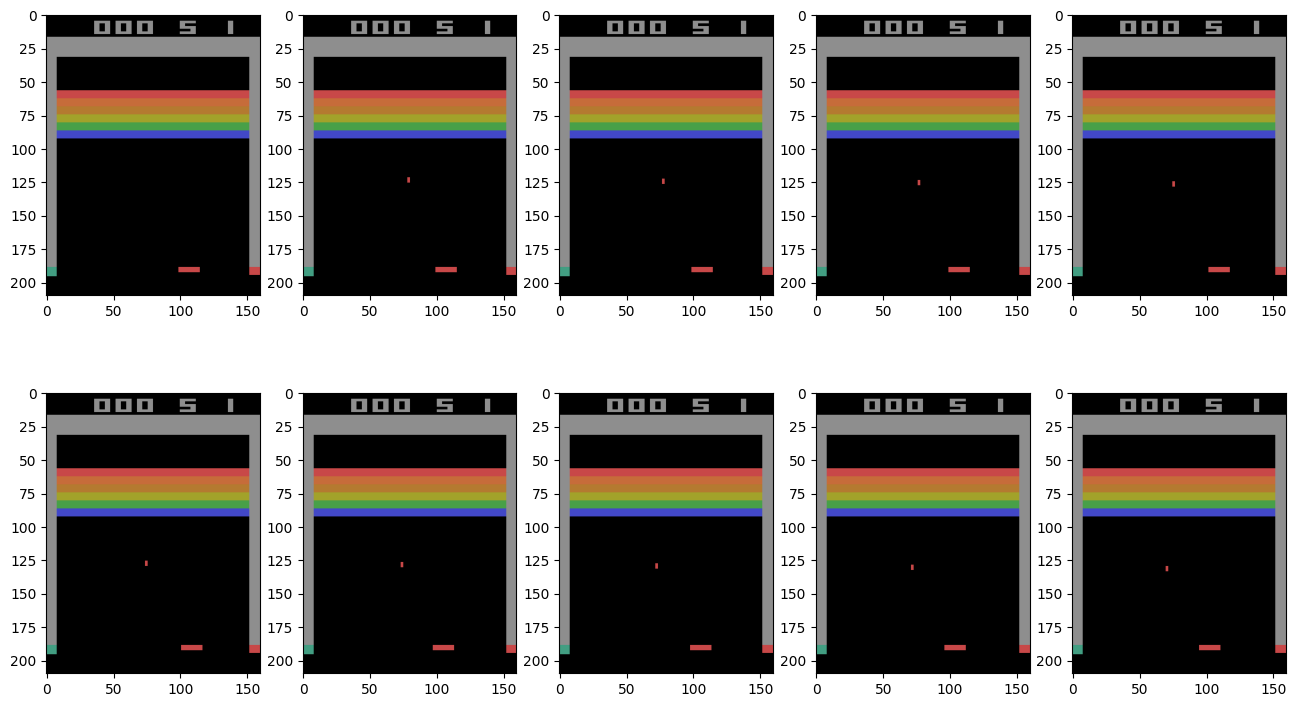

In [ ]:
import gym

ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [ ]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

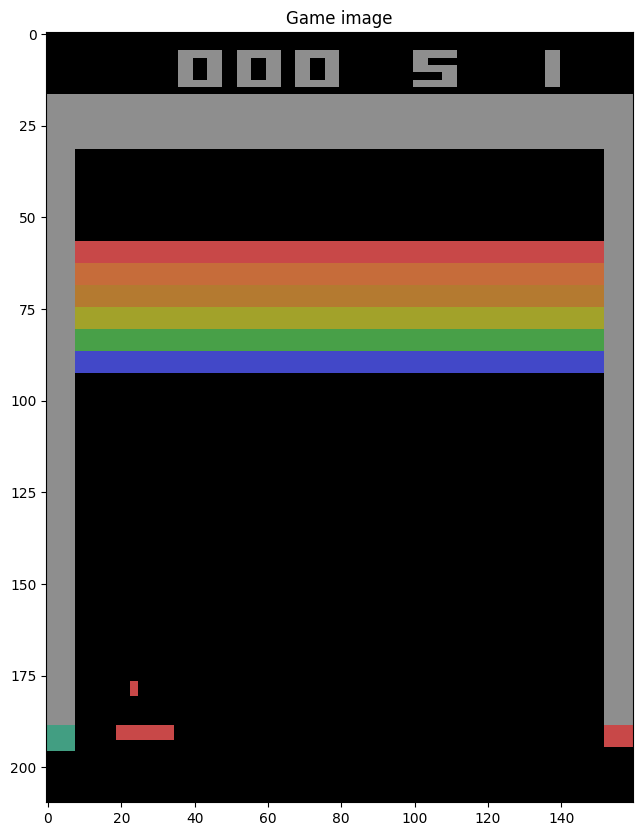

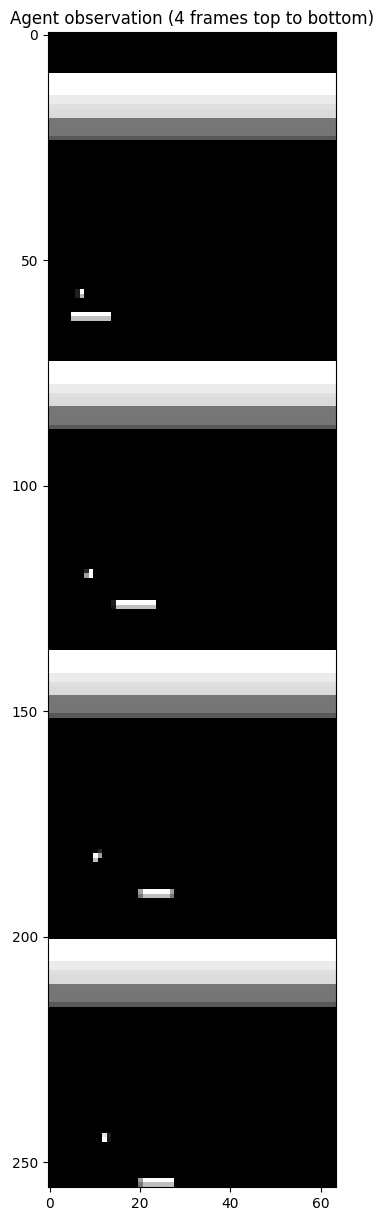

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [ ]:
import numpy as np
import random

class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action(self, qvalues):
    roll = np.random.rand()
    if(roll < self._epsilon):
      action = env.action_space.sample()
    else:
      action =  torch.argmax(qvalues).item()
    return action

class DecayEpsilonGreedy(EpsilonGreedy):

  def __init__(self, epsilon, factor):
    super().__init__(epsilon)
    self._factor = factor

  def get_action(self, qvalues):
    action = super().get_action(qvalues)
    self._epsilon = max(self._epsilon - self._factor, 0.001)

    return action

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from einops.layers.torch import Rearrange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = nn.Sequential(*[
            nn.Conv2d(4 * in_chs, in_chs, 3, 1, 1),
            nn.GELU()])

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super(DownBlock, self).__init__()
        layers = [nn.Conv2d(in_chs, out_chs, 3, 1, 1),
                  nn.GELU(),
                  nn.Conv2d(out_chs, out_chs, 3, 1, 1),
                  nn.GELU(),
                  RearrangePoolBlock(out_chs)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class QNetwork(nn.Module):
  def __init__(self, input_dim=(4,64,64), output_dim=(4), hidden_size=512):
    super(QNetwork, self).__init__()

    self.down1 = DownBlock(input_dim[0], 32)
    self.down2 = DownBlock(32, 64)

    self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

    latent_image_size = input_dim[1] // 4

    self.dense = nn.Sequential(
            nn.Linear(64 * latent_image_size**2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_dim),
        )

  def forward(self, x):

    x = self.down1(x)
    x = self.down2(x)
    x = self.to_vec(x)
    x = self.dense(x)
    return x

In [ ]:
OBSERVATION_SHAPE = env.observation_space.shape # (4, 64, 64)
NUM_ACTS = env.action_space.n                   # 4

MAX_CAPICITY = 10_000
BATCH_SIZE = 32

In [ ]:
class Agent(object):

    def __init__(self, hidden_size, discount, epsilon):

        self.action_policy   = DecayEpsilonGreedy(epsilon, 9.99e-5)
        self.replay_buffer   = deque([], maxlen=MAX_CAPICITY)
        self.discount        = discount

        self.target_net   = QNetwork(OBSERVATION_SHAPE, NUM_ACTS, hidden_size).to(device)
        self.behavior_net = QNetwork(OBSERVATION_SHAPE, NUM_ACTS, hidden_size).to(device)

        self.target_net.load_state_dict(self.behavior_net.state_dict())
        self.target_net.eval()

        self.criterion = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.behavior_net.parameters(), lr=1e-4)

    def sample_batch(self, batch_size):
        batch  = random.sample(self.replay_buffer, batch_size)
        state  = torch.stack ([sample[0] for sample in batch])
        action = torch.tensor([sample[1] for sample in batch], device=device)
        reward = torch.tensor([sample[2] for sample in batch], device=device)
        next_s = torch.stack ([sample[3] for sample in batch])
        done = torch.stack ([sample[4] for sample in batch])
        return state,action,reward,next_s,done

    def optimize(self):

        batch_size                            = min(len(self.replay_buffer), BATCH_SIZE)
        state, action, reward, next_s, done   = self.sample_batch(batch_size)

        behavior                             = self.behavior_net(state)

        Q_behavior                           = behavior[torch.arange(behavior.size(0)),action]

        Q_values                             = self.target_net(next_s)
        bootstrap, _                         = torch.max(Q_values, dim=1)

        targets = torch.where(done, reward, reward + self.discount * bootstrap)

        self.optimizer.zero_grad()
        loss = self.criterion(targets, Q_behavior)
        loss.backward()

        self.optimizer.step()

        return loss.item()

    def update(self, state, action, reward, next_state, done):

        if reward is not None:
            self.replay_buffer.append([state, action, reward, next_state, done])

        return self.optimize()

    def step(self, state):
        qvalues = self.behavior_net(state.unsqueeze(0))
        return self.action_policy.get_action(qvalues)


In [ ]:
agent = Agent(hidden_size=256, discount=0.99, epsilon=1)

n_games = 10_000
step = 0

for game_num in range(n_games):

    s = torch.tensor(env.reset(), device=device)
    done = False

    while not done:
        action = agent.step(s)
        step += 1

        next_s, r, done, _ = env.step(action)

        r = torch.tensor(r, device=device, dtype=torch.float32)
        done = torch.tensor(done, device=device)
        next_s = torch.tensor(next_s, device=device)

        agent.update(s, action, r, next_s, done)

        s = next_s

        if step % 1000 == 0:
            agent.target_net.load_state_dict(agent.behavior_net.state_dict())

        if done:
            break

In [ ]:
def evaluate_DQN(env, agent, n_games=1, t_max=10000):
    rewards = []

    for _ in range(n_games):
        s = torch.tensor(env.reset(), device=device)
        reward = 0
        done = False
        while not done:
            action = agent.step(s)
            previous_state = s
            s, r, done, _ = env.step(action)
            s = torch.tensor(s, device=device)
            reward += r
            if done:
              break
        rewards.append(reward)
    return np.mean(rewards)

agent.target_net.eval()
agent.behavior_net.eval()
mean_reward = evaluate_DQN(env, agent, n_games=5)

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate_DQN(env_monitor, agent, n_games=5) for _ in range(10)]

In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))